# Tutorial for *BiLO: Bi-Level Local Operator for PDE inverse problem*

In [1]:
import sys
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# set seed
torch.manual_seed(0)

In [2]:
class DenseNet(nn.Module):
    '''General class for a dense neural network with a variable number of layers and width.'''
    def __init__(self, depth=4, width=64, 
                 output_transform=lambda x, u: u):
        super(DenseNet, self).__init__()
        input_dim = 1
        output_dim = 1
        self.width = width
        self.depth = depth
        self.activation = torch.tanh
        layers = []

        # input layer/embeding layer
        self.input_layer = nn.Linear(input_dim, width)

        # hidden layers (depth - 2)
        self.hidden_layers = nn.ModuleList([nn.Linear(width, width) for _ in range(depth - 2)])
        self.output_layer = nn.Linear(width, output_dim)
        
        # Store the output transformation function
        self.output_transform = output_transform
    

    def forward(self, x):
        # Define the forward pass
        act = self.activation
        u = act(self.input_layer(x))
        for layer in self.hidden_layers:
            u = act(layer(u))
        u = self.output_layer(u)
        
        return self.output_transform(x, u)


In [3]:
class ScalarPoisson():
    ''' Class for the scalar Poisson equation D u_xx = f(x) on the domain [0, 1] with Dirichlet boundary conditions.'''
    def __init__(self, D = 1.0):
        self.D = D
        self.p = 1
        self.dataset = {}
    
    def f(self, x):
        ''' fixed forcing term'''
        return -(torch.pi * self.p)**2 * torch.sin(torch.pi * self.p * x)

    def u_exact(self, x, D):
        ''' exact PDE solution for given D '''
        return torch.sin(torch.pi * self.p * x) / D
    
    def get_dataset(self, D0, N_res_train, N_dat_train, N_res_test, N_dat_test, variance = None):
        ''' Generate a dataset for the scalar Poisson equation.'''
        
        self.D0 = D0
        self.dataset['D0'] = self.D0
        self.dataset['D'] = self.D

        self.N_res_train = N_res_train
        self.N_dat_train = N_dat_train
        self.N_res_test = N_res_test
        self.N_dat_test = N_dat_test

        # Collocation points for residual loss
        self.dataset['x_res_train'] = torch.linspace(0, 1, N_res_train).view(-1, 1)
        self.dataset['x_res_test'] = torch.linspace(0, 1, N_res_test).view(-1, 1)

        # Collocation points for data loss
        self.dataset['x_dat_test'] = torch.linspace(0, 1, N_dat_test).view(-1, 1)
        self.dataset['x_dat_train'] = torch.linspace(0, 1, N_dat_train).view(-1, 1)
        
        # use exact D for testing
        self.dataset['ugt_dat_test'] = self.u_exact(self.dataset['x_dat_test'], self.D)

        # use D0 for pre-training
        self.dataset['u0_dat_train'] = self.u_exact(self.dataset['x_dat_train'], self.D0)

        # u at ground truth D
        u = self.u_exact(self.dataset['x_dat_train'], self.D)

        # add noise to the data if variance is not None
        if variance is None:
            noise = 0
        else:
            noise = torch.randn_like(u) *  torch.sqrt(torch.tensor(variance))
        
        # (noisy) data for fine-tuning
        self.dataset['u_dat_train'] = u + noise


In [4]:
class VanillaPINN(nn.Module):
    def __init__(self, net, pde):
        super(VanillaPINN, self).__init__()
        
        self.net = net
        self.pde = pde
        self.dataset = pde.dataset

        # initialize the diffusion coefficient as D0
        self.D = nn.Parameter(torch.tensor(pde.dataset['D0']))

    def residual_loss(self):
        x = self.dataset['x_res_train']
        x.requires_grad = True

        u = self.net(x)

        u_x = torch.autograd.grad(u, x,
            create_graph=True, retain_graph=True, grad_outputs=torch.ones_like(u))[0]
        u_xx = torch.autograd.grad(u_x, x,
            create_graph=True, retain_graph=True, grad_outputs=torch.ones_like(u_x))[0]
        res = self.D * u_xx - self.pde.f(x)

        # compute the loss
        loss = torch.mean(res**2)
        return loss

    def pretrain_data_loss(self):
        ''' For pre-training, we use the solution of the PDE with the initial guess for the diffusion coefficient as the target.'''
        x = self.dataset['x_dat_train']
        u_dat = self.dataset['u0_dat_train']
        
        u = self.net(x)
        loss = torch.mean((u - u_dat)**2)
        return loss

    def finetune_data_loss(self):
        ''' For fine-tuning, we use the (noisy) solution of the PDE with the exact diffusion coefficient as the target.'''
        x  = self.dataset['x_dat_train']
        u_dat = self.dataset['u_dat_train']

        u  = self.net(x)
        loss = torch.mean((u - u_dat)**2)
        return loss
    
    def pretrain(self, max_iter):
        ''' Pre-train the neural network using the initial guess for the diffusion coefficient.'''
        # only train the weight of network, not the paraeter D
        self.D.requires_grad = False
        optimizer = torch.optim.Adam(self.net.parameters(), lr=1e-3)

        # training loop
        for step in range(max_iter):
            optimizer.zero_grad()
            resloss = self.residual_loss() 
            dataloss = self.pretrain_data_loss()
            loss = resloss + dataloss
            # print statistics
            if step % 100 == 0:
                print(f'Step {step}, Loss: {loss.item():.3e}, resloss: {resloss.item():.3e}, dataloss: {dataloss.item():.3e}, D: {self.D.item():.3f}')
            loss.backward()
            optimizer.step()
    
    def validate(self):
        ''' error of param prediction'''
        err = self.pde.D - self.D.item()
        return err

    def finetune(self, max_iter, wdata = 1.0):
        ''' Fine-tune the neural network using the data to solve the inverse problem'''

        # D is trainable
        self.D.requires_grad = True

        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        for step in range(max_iter):
            optimizer.zero_grad()
            resloss = self.residual_loss()
            dataloss = self.finetune_data_loss()
            loss = resloss + dataloss * wdata

            err = self.validate()
            if step % 100 == 0:
                print(f'Step {step}, Loss: {loss.item():.3e}, resloss: {resloss.item():.3e}, dataloss: {dataloss.item():.3e}, D: {self.D.item():.3f}', f'err: {err:.3e}')
            
            loss.backward()
            optimizer.step()

    

In [6]:
class LocalOperator(DenseNet):
    '''represent u(x, p), where p is the parameter of the PDE'''
    def __init__(self, fdepth=4, fwidth=64, 
                 output_transform=lambda x, u: u):
        super().__init__(fdepth, fwidth, output_transform)

        # embedding layer
        self.param_embeddings = nn.Linear(1, self.width, bias=True)
        # set requires_grad to False
        for embedding_weights in self.param_embeddings.parameters():
            embedding_weights.requires_grad = False
        
        self.params_expand = None

    def embedding(self, x, z):
        '''
        if with_param, then Wy+b + W'p+b' (pde parameter embedding)
        This is the same as concat [x, pde_param] and then do a linear layer
        otherwise, then Wy+b
        '''
        
        # fourier feature embedding
        xcoord  = x
        x = self.input_layer(x)

        # expand the parameter to the same size as x
        self.params_expand = z.expand(x.shape[0], -1) # (batch, 1)
        param_embedding = self.param_embeddings(self.params_expand)
        x += param_embedding
        return x

    def forward(self, x , z):
        # Define the forward pass
        X = self.embedding(x, z)
        X = self.activation(X)
        for layer in self.hidden_layers:
            X = self.activation(layer(X))
        u = self.output_layer(X)
        
        return self.output_transform(x, u)

class Bilo(nn.Module):
    def __init__(self, localOp, pde):
        super(Bilo, self).__init__()
        
        self.localOp = localOp
        self.pde = pde
        self.dataset = pde.dataset

        D0 = pde.dataset['D0']
        self.D = nn.Parameter(torch.tensor([[D0]]), requires_grad=True)

        self.param_net = [v for v in self.localOp.parameters() if v.requires_grad]
        self.param_pde = [self.D]

        self.wresgrad = 1e-3

    def residual_grad_loss(self):
        x = self.dataset['x_res_train']
        x.requires_grad = True
        u = self.localOp(x, self.D)

        u_x = torch.autograd.grad(u, x,
            create_graph=True, retain_graph=True, grad_outputs=torch.ones_like(u))[0]
        u_xx = torch.autograd.grad(u_x, x,
            create_graph=True, retain_graph=True, grad_outputs=torch.ones_like(u_x))[0]
        res = self.localOp.params_expand * u_xx - self.pde.f(x)

        resgrad = torch.autograd.grad(res, self.localOp.params_expand, grad_outputs=torch.ones_like(res),
        create_graph=True, allow_unused=True)[0]
        
        # compute the loss
        res_loss = torch.mean(res**2)

        res_grad_loss = torch.mean(resgrad**2)
        
        return  res_loss, res_grad_loss
    
    def pretrain_data_loss(self):
        x = self.dataset['x_dat_train']
        u = self.localOp(x, self.D)
        u_dat = self.dataset['u0_dat_train']

        loss = torch.mean((u - u_dat)**2)
        return loss

    def finetune_data_loss(self):
        x  = self.dataset['x_dat_train']
        u  = self.localOp(x, self.D)

        u_dat = self.dataset['u_dat_train']
        loss = torch.mean((u - u_dat)**2)
        return loss
    
    def pretrain(self, max_iter):
        optimizer = torch.optim.Adam(self.localOp.parameters(), lr=1e-3)
        for step in range(max_iter):
            optimizer.zero_grad()
            res_loss, resgrad_loss = self.residual_grad_loss()
            data_loss = self.pretrain_data_loss()
            total_loss = res_loss + self.wresgrad * resgrad_loss + data_loss
            total_loss.backward()
            optimizer.step()
            if step % 100 == 0:
                print(f'Step {step}, res_loss: {res_loss.item():.3e}, resgrad_loss: {resgrad_loss.item():.3e}, data_loss: {data_loss.item():.3e}, D: {self.D.item():.3f}')
            
    
    def finetune(self, max_iter):
        
        optim_param_group = [
                {'params': self.param_net, 'lr': 1e-3},
                {'params': self.param_pde, 'lr': 1e-3}
            ]
        optimizer = torch.optim.Adam(optim_param_group)

        for step in range(max_iter):
            
            # compute the gradient of the loss w.r.t. the pde parameter
            data_loss = self.finetune_data_loss()
            grads_param = torch.autograd.grad(data_loss, self.D, create_graph=True, allow_unused=True)
            self.D.grad = grads_param[0]
            
            # compute the gradient of the loss w.r.t. the network parameters
            res_loss, resgrad_loss = self.residual_grad_loss()
            
            net_loss = res_loss + resgrad_loss * self.wresgrad

            grads_net = torch.autograd.grad(net_loss, self.param_net, create_graph=True, allow_unused=True)
            for i, param in enumerate(self.param_net):
                param.grad = grads_net[i]
            
            optimizer.step()
            if step % 100 == 0:
                print(f'Step {step}, res_loss: {res_loss.item():.3e}, resgrad_loss: {resgrad_loss.item():.3e}, data_loss: {data_loss.item():.3e}, D: {self.D.item():3f}')


            

In [ ]:
n_res_train = 11
n_dat_train = 11
n_res_test = 101
n_dat_test = 101
variance = 0.0001
max_iter = 5000
D_gt = 2.0 # ground truth D
D0 = 1.0 # initial guess for D
pde = ScalarPoisson(D=D_gt)
pde.get_dataset(D0, n_res_train, n_dat_train, n_res_test, n_dat_test, variance=variance)

In the pre-training stage, we train BiLO with initial guess $D_0 = 1$. The inclusion of the data loss is optional in this case, but we include it for speed.

In [7]:
localop = LocalOperator(output_transform=lambda x, u: u * (1 - x)*x)
bilo = Bilo(localop, pde)
max_iter = 5000
bilo.pretrain(max_iter)

Step 0, res_loss: 4.109e+01, resgrad_loss: 3.575e-02, data_loss: 4.214e-01, D: 1.000
Step 100, res_loss: 1.623e-02, resgrad_loss: 6.689e+01, data_loss: 7.032e-06, D: 1.000
Step 200, res_loss: 4.935e-03, resgrad_loss: 6.237e+01, data_loss: 1.281e-06, D: 1.000
Step 300, res_loss: 3.584e-03, resgrad_loss: 5.794e+01, data_loss: 1.234e-06, D: 1.000
Step 400, res_loss: 2.518e-03, resgrad_loss: 5.302e+01, data_loss: 1.029e-06, D: 1.000
Step 500, res_loss: 1.489e-03, resgrad_loss: 4.756e+01, data_loss: 8.649e-07, D: 1.000
Step 600, res_loss: 7.573e-04, resgrad_loss: 4.147e+01, data_loss: 7.476e-07, D: 1.000
Step 700, res_loss: 4.069e-04, resgrad_loss: 3.458e+01, data_loss: 6.717e-07, D: 1.000
Step 800, res_loss: 2.722e-04, resgrad_loss: 2.678e+01, data_loss: 6.022e-07, D: 1.000
Step 900, res_loss: 2.094e-04, resgrad_loss: 1.841e+01, data_loss: 5.079e-07, D: 1.000
Step 1000, res_loss: 1.681e-04, resgrad_loss: 1.060e+01, data_loss: 3.673e-07, D: 1.000
Step 1100, res_loss: 1.362e-04, resgrad_loss

After pre-training at $D_0$, we can evaluate the local operator at its neighborhood $D_0 + \Delta$.
Because of the residual-gradient loss, the local operator is able to approximate the true PDE solution at the neighborhood $D_0 + \Delta$

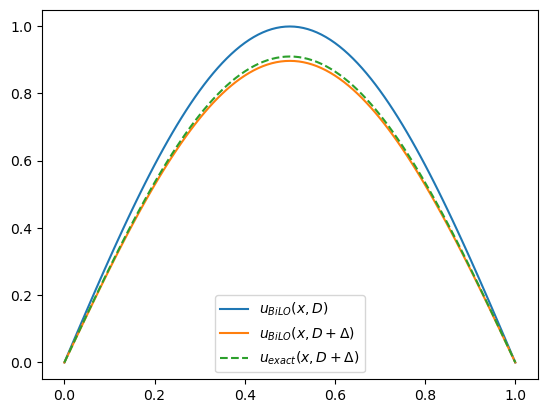

In [8]:
delta = 0.1
with torch.no_grad():
    x = pde.dataset['x_res_test']
    u = bilo.localOp(x, bilo.D)
    u_var = bilo.localOp(x, bilo.D + delta)

# plot prediction
plt.plot(x, u, label='$u_{BiLO}(x,D)$')
# plot prediction at D + delta
plt.plot(x, u_var, label='$u_{BiLO}(x,D+\Delta)$')
# plot solution with predicted D
plt.plot(x, pde.u_exact(x, bilo.D.item()+delta), label='$u_{exact}(x,D+\Delta)$', linestyle='--')

plt.legend()
plt.show()

Next, we solve the inverse problem with the noisy data.

In [9]:
bilo.finetune(max_iter)

Step 0, res_loss: 2.329e-04, resgrad_loss: 5.721e-03, data_loss: 1.155e-01, D: 1.001000
Step 100, res_loss: 1.016e-05, resgrad_loss: 9.178e-01, data_loss: 7.955e-02, D: 1.096781
Step 200, res_loss: 5.819e-06, resgrad_loss: 9.424e-01, data_loss: 5.676e-02, D: 1.181010
Step 300, res_loss: 3.585e-06, resgrad_loss: 3.825e-01, data_loss: 4.256e-02, D: 1.250751
Step 400, res_loss: 2.887e-06, resgrad_loss: 1.423e-01, data_loss: 3.312e-02, D: 1.309729
Step 500, res_loss: 2.611e-06, resgrad_loss: 6.579e-02, data_loss: 2.636e-02, D: 1.361569
Step 600, res_loss: 6.703e-03, resgrad_loss: 4.895e-02, data_loss: 2.076e-02, D: 1.408546
Step 700, res_loss: 2.677e-06, resgrad_loss: 2.512e-02, data_loss: 1.735e-02, D: 1.451447
Step 800, res_loss: 8.325e-05, resgrad_loss: 1.533e-02, data_loss: 1.427e-02, D: 1.491128
Step 900, res_loss: 2.367e-06, resgrad_loss: 1.582e-02, data_loss: 1.178e-02, D: 1.527916
Step 1000, res_loss: 6.700e-06, resgrad_loss: 1.691e-02, data_loss: 9.782e-03, D: 1.562083
Step 1100, 

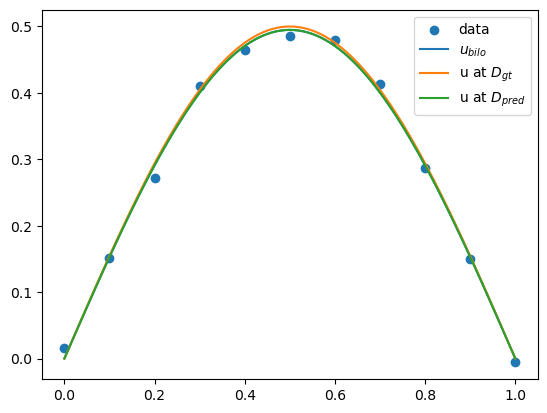

In [11]:
with torch.no_grad():
    x = pde.dataset['x_res_test']
    u = bilo.localOp(x, bilo.D)

# plot data
plt.scatter(pde.dataset['x_dat_train'], pde.dataset['u_dat_train'], label='data')
# plot prediction
plt.plot(x, u, label='$u_{bilo}$')
# plot solution with ground truth D
plt.plot(x, pde.u_exact(x, pde.D), label='u at $D_{gt}$')
# plot solution with predicted D
plt.plot(x, pde.u_exact(x, bilo.D.item()), label='u at $D_{pred}$')

plt.legend()
plt.show()